In this notebook we demonstrate Gaussian prepivoting for the $\sqrt{N}$-scaled absolute difference in means.  We use a completely randomized experiment and we take a finite-population-inferential approach.  For more information on the methods here, see https://arxiv.org/abs/2002.06654.

# Generate Some Data

In [22]:
###########################################
#              Generate Data              #
###########################################
# Some algorithm hyperparameters
numIters = 5000
numMonteCarlo = 100

# First we make some synthetic data for our experiments
N = 10000 # the number of units
p = .3 # porportion of treated units
nt = floor(N*p) # number of treated
nc = N - nt # number of control

# Handy variables
treatind = c(rep(T, nt), rep(F, nc))

# Superpopulation level parameters
SdT = 20
SdC = 1
SigmaX = cbind(c(1,.5, .2), c(.5,1,.3), c(.2,.3,1))
betaT = c(1,2,3)*.2
betaC = c(-1,-2, 4)*.8

# Taubar is the average additive treatment effect
taubar = 0

# Make covariates and potential outcomes (Gaussian model with noisey linear relations)
X = mvtnorm::rmvnorm(N, c(0,0,0), SigmaX)
Yttemp = X%*%betaT + rnorm(N, 0, SdT)
Yc = X%*%betaC + rnorm(N, 0, SdC) # The control POs
Yt = Yttemp - mean(Yttemp - Yc) + taubar # The treated POs (this centering forces Neyman's null to hold)

Z = sample(treatind, replace = FALSE) # Select a treatment allocation for a CRE design

# This is what the experimenter gets to see
Yobs = Z*Yt + (1 - Z)*Yc
Ytreat = Yt[Z]
Ycontrol = Yc[!Z]
Xtreat = X[Z,]
Xcontrol = X[!Z,]
Xtreat = data.frame(Xtreat)
Xcontrol = data.frame(Xcontrol)

# Generate the *true* randomization distribution.

In [23]:
randomizationDistribution = numeric(numIters)
for(rand in 1:numIters)
{
    treatmentAlloc = sample(treatind, replace = FALSE) # Select a treatment allocation for a CRE design

    # This is what the experimenter gets to see
    Yobs = treatmentAlloc*Yt + (1 - treatmentAlloc)*Yc
    Ytreat = Yt[treatmentAlloc]
    Ycontrol = Yc[!treatmentAlloc]
    Xtreat = X[treatmentAlloc,]
    Xcontrol = X[!treatmentAlloc,]
    Xtreat = data.frame(Xtreat)
    Xcontrol = data.frame(Xcontrol)
    
    randomizationDistribution[rand] = sqrt(N)*abs(mean(Ytreat) - mean(Ycontrol))
}

# Observe a single realization of the experiment.

In [24]:
Z = sample(treatind, replace = FALSE) # Select a treatment allocation for a CRE design

# This is what the experimenter gets to see
Yobs = Z*Yt + (1 - Z)*Yc
Ytreat = Yt[Z]
Ycontrol = Yc[!Z]
Xtreat = X[Z,]
Xcontrol = X[!Z,]
Xtreat = data.frame(Xtreat)
Xcontrol = data.frame(Xcontrol)

# Generate the *reference* distribution.

In [25]:
referenceDistribution = numeric(numIters)
for(sim in 1:numIters)
{
    pseudoTreatmentAllocation = sample(treatind, replace = FALSE) # Select a treatment allocation for a CRE design
    
    # Impute counterfactuals "as if Fisher's sharp null held" (even if inference is desired for Neyman's weak null)
    imputedYtreat = Yobs[pseudoTreatmentAllocation]
    imputedYcontrol = Yobs[!pseudoTreatmentAllocation]

    referenceDistribution[sim] = sqrt(N)*abs(mean(imputedYtreat) - mean(imputedYcontrol))
}

# Visualize the two distributions.

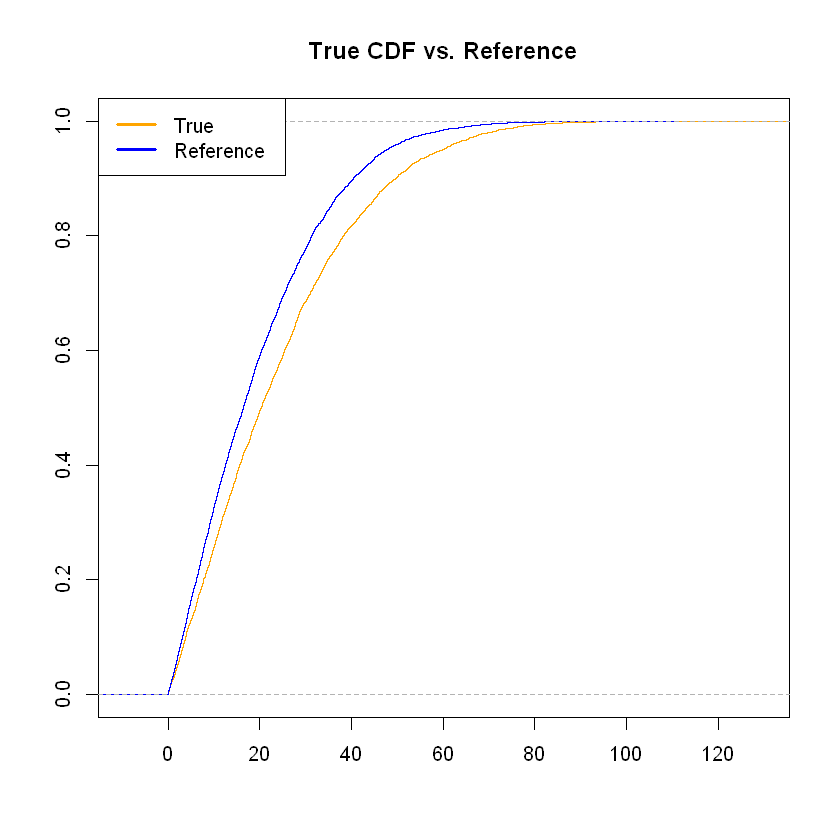

In [26]:
plot.ecdf(randomizationDistribution, col = 'orange', main = 'True CDF vs. Reference', xlab = '', ylab = '')
plot.ecdf(referenceDistribution, add = TRUE, col = 'blue')
legend(x = 'topleft', legend = c('True', 'Reference'), col = c('orange', 'blue'), lwd = c(3, 3))

# Summary:
The reference distribution lies above the true distribution, so inferences based upon the reference distribution are *anticonservative* with respect to the true data-generating distribution.

# Now we apply Gaussian prepivoting.

Just like before, we will first figure out the *true* distribution of the prepivoted statistic (which is not computable by the experimenter because she does not get to observe counterfactual outcomes).

In [27]:
prepivottedStatistic = function(treatedOutcomes, controlOutcomes, numGaussian = 100)
{
    nt = length(treatedOutcomes)
    nc = length(controlOutcomes)
    N = nt + nc
    
    unprepivotedStatistic = sqrt(N)*abs(mean(treatedOutcomes) - mean(controlOutcomes))
    
    # Neyman's classical variance estimator for the difference in means
    varEst = (var(treatedOutcomes)/nt) + (var(controlOutcomes)/nc) 
    
    # Gaussian prepivot by using Monte-Carlo approximation to the pushforward measure
    MCapprox = numeric(numMonteCarlo)
    for(b in 1:numMonteCarlo)
    {
        gaussianDraw = mvtnorm::rmvnorm(n = 1, sigma = as.matrix(varEst))
        MCapprox[b] = sqrt(N)*abs(gaussianDraw)
    }
    prepivResult = mean(MCapprox <= unprepivotedStatistic) # The prepivoted statistic
    return(prepivResult)
}

# Generate the *true* randomization distribution of the prepivoted statistic.

In [28]:
prepivRandomizationDistribution = numeric(numIters)
for(rand in 1:numIters)
{
    treatmentAlloc = sample(treatind, replace = FALSE) # Select a treatment allocation for a CRE design

    # This is what the experimenter gets to see
    Yobs = treatmentAlloc*Yt + (1 - treatmentAlloc)*Yc
    Ytreat = Yt[treatmentAlloc]
    Ycontrol = Yc[!treatmentAlloc]
    Xtreat = X[treatmentAlloc,]
    Xcontrol = X[!treatmentAlloc,]
    Xtreat = data.frame(Xtreat)
    Xcontrol = data.frame(Xcontrol)
        
    prepivRandomizationDistribution[rand] = prepivottedStatistic(treatedOutcomes = Ytreat, controlOutcomes = Ycontrol)
}

# Generate the *reference* distribution.
For this we use the same realization of the CRE that we used before.

In [29]:
prepivReferenceDistribution = numeric(numIters)
for(sim in 1:numIters)
{
    pseudoTreatmentAllocation = sample(treatind, replace = FALSE) # Select a treatment allocation for a CRE design
    
    # Impute counterfactuals "as if Fisher's sharp null held" (even if inference is desired for Neyman's weak null)
    imputedYtreat = Yobs[pseudoTreatmentAllocation]
    imputedYcontrol = Yobs[!pseudoTreatmentAllocation]

    prepivReferenceDistribution[sim] = prepivottedStatistic(treatedOutcomes = imputedYtreat, controlOutcomes = imputedYcontrol)
}

# Visualize the two distributions.

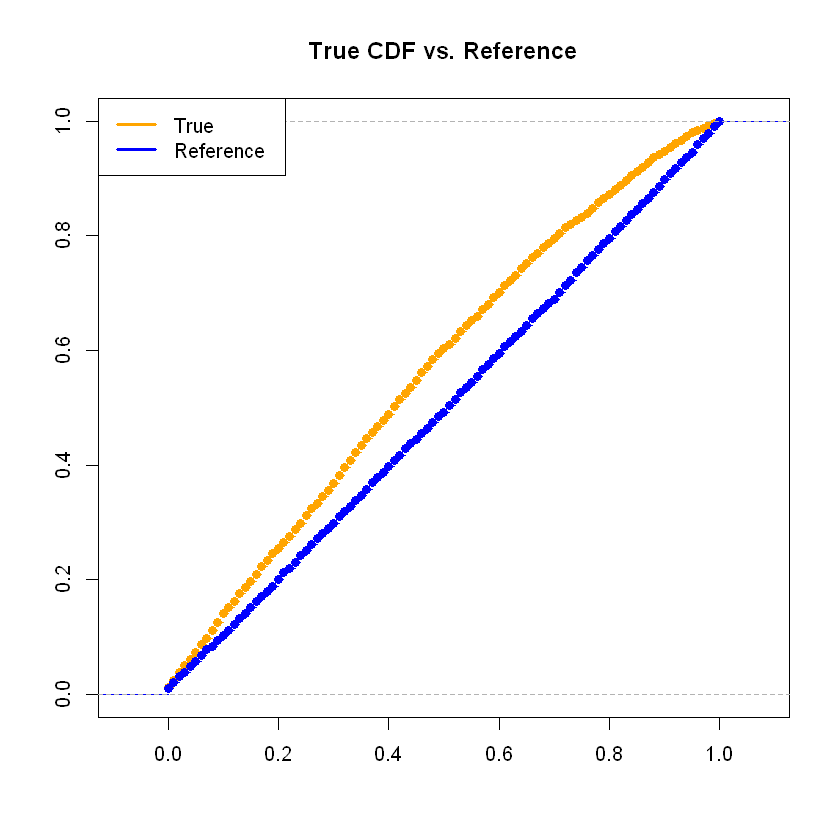

In [30]:
plot.ecdf(prepivRandomizationDistribution, col = 'orange', main = 'True CDF vs. Reference', xlab = '', ylab = '')
plot.ecdf(prepivReferenceDistribution, add = TRUE, col = 'blue')
legend(x = 'topleft', legend = c('True', 'Reference'), col = c('orange', 'blue'), lwd = c(3, 3))

# Summary:
Now the reference distribution lies below the true distribution, so inferences based upon the reference distribution are *conservative* with respect to the true data-generating distribution.

In this particular case -- when the test statistic is $T(y(Z), Z) = \sqrt{N} \hat{\tau}(y(Z), Z)$ -- studentizing would have fixed the original problem of anticonservative inference.  However, there are numerous examples of interesting test statistics $T(y(Z), Z)$ where studentization is either:
(a) not yet figured out for the particular design & statistic at hand, or
(b) not sufficient to rectify the issue of anticonservative inference under the reference distribution.

For examples of both of these, see https://arxiv.org/abs/2002.06654.  In that paper we show that -- subject to mild conditions -- Gaussian prepivoting gives an automatic solution for situation (a): no clever studentizing or complex case-by-case analysis needed, just use Gaussian prepivoting! For situation (b), Gaussian prepivoting still works: no need to give up because studentizing is insufficient.